# Rain in Australia  
### Predicting next-day rain by classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from xgboost import XGBClassifier
import lightgbm as lgb

## Data exploration

In [2]:
weather_data = pd.read_csv("weatherAUS.csv")
weather_data.shape

(145460, 23)

In [3]:
weather_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Data Dictionary  
- **Date** - The date of observation  
- **Location** - The common name of the location of the weather station
- **MinTemp** - The minimum temperature in degrees celsius
- **MaxTemp** - The maximum temperature in degrees celsius
- **Rainfall** - The amount of rainfall recorded for the day in mm
- **Evaporation** - The so-called Class A pan evaporation (mm) in the 24 hours to 9am
- **Sunshine** - The number of hours of bright sunshine in the day
- **WindGustDir** - The direction of the strongest wind gust in the 24 hours to midnight
- **WindGustSpeed** - The speed (km/h) of the strongest wind gust in the 24 hours to midnight
- **WindDir9am** - Direction of the wind at 9am
- **WindDir3pm** - Direction of the wind at 3pm
- **WindSpeed9am** - Wind speed (km/hr) averaged over 10 minutes prior to 9am
- **WindSpeed3pm** - Wind speed (km/hr) averaged over 10 minutes prior to 3pm
- **Humidity9am** - Humidity (percent) at 9am
- **Humidity3pm** - Humidity (percent) at 3pm
- **Pressure9am** - Atmospheric pressure (hpa) reduced to mean sea level at 9am
- **Pressure3pm** - Atmospheric pressure (hpa) reduced to mean sea level at 3pm
- **Cloud9am** - Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
- **Cloud3pm** - Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
- **Temp9am** - Temperature (degrees C) at 9am
- **Temp3pm** - Temperature (degrees C) at 3pm
- **RainToday** - "Yes" if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise "No"
- **RainTomorrow** - Did it rain the next day - "Yes" or "No"

In [4]:
weather_data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [5]:
weather_data_dict = {
    "Data type": weather_data.dtypes,
    "NA count": weather_data.isna().sum(),
    "Unique values": weather_data.nunique()
}
feature_dt_na = pd.DataFrame(weather_data_dict)
feature_dt_na

,Data type,NA count,Unique values
Date,object,0,3436
Location,object,0,49
MinTemp,float64,1485,389
MaxTemp,float64,1261,505
Rainfall,float64,3261,681
Evaporation,float64,62790,358
Sunshine,float64,69835,145
WindGustDir,object,10326,16
WindGustSpeed,float64,10263,67
WindDir9am,object,10566,16


**There are only two data types present in the dataset: objects and floats.  
Some of the features have a lot of missing values, mainly: Sunshine, Evaporation, Cloud9am and Cloud3pm.  
All four of these features are floats.**

In [6]:
#Splitting features by type for further exploration
feature_object = feature_dt_na[feature_dt_na['Data type'] == 'object']
feature_float = feature_dt_na[feature_dt_na['Data type'] == 'float64']

### Objects - exploration & extraction

In [7]:
feature_object

,Data type,NA count,Unique values
Date,object,0,3436
Location,object,0,49
WindGustDir,object,10326,16
WindDir9am,object,10566,16
WindDir3pm,object,4228,16
RainToday,object,3261,2
RainTomorrow,object,3267,2


In [8]:
weather_data['RainToday'].value_counts()

No     110319
Yes     31880
Name: RainToday, dtype: int64

In [9]:
weather_data['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

**Both RainToday and RainTomorrow are either "No" or "Yes" and the values are unbalanced.  
RainTomorrow is the target of classification.**

In [10]:
#Removal of null RainToday and RainTommorow
weather_data.dropna(subset="RainToday", inplace=True)
weather_data.dropna(subset="RainTomorrow", inplace=True)

#Transforming RainToday & RainTomorrow values into binary ones
weather_data['RainToday'].replace(('Yes', 'No'), (1, 0), inplace=True)
weather_data['RainTomorrow'].replace(('Yes', 'No'), (1, 0), inplace=True)

In [11]:
#Date column could be split into three columns: Year, Month and Day (all integers)
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

weather_data["Year"] = weather_data["Date"].dt.year
weather_data["Month"] = weather_data["Date"].dt.month
weather_data["Day"] = weather_data["Date"].dt.day

In [12]:
weather_data["Year"].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2007],
      dtype=int64)

In [13]:
#Dropping Date column
weather_data = weather_data.drop("Date", axis=1)
weather_data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,0,0,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,0,0,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,0,0,2008,12,5


In [14]:
#Imputation using mode

weather_data['WindGustDir'] = weather_data['WindGustDir'].fillna(weather_data['WindGustDir'].mode()[0])
weather_data['WindDir9am'] = weather_data['WindDir9am'].fillna(weather_data['WindDir9am'].mode()[0])
weather_data['WindDir3pm'] = weather_data['WindDir3pm'].fillna(weather_data['WindDir3pm'].mode()[0])

In [15]:
weather_data["Location"].value_counts()

Canberra            3402
Sydney              3331
Perth               3193
Darwin              3192
Hobart              3183
Brisbane            3132
Bendigo             3030
Townsville          3027
AliceSprings        3025
MountGambier        3022
Launceston          3020
Adelaide            3020
Ballarat            3017
PerthAirport        3009
MelbourneAirport    3009
Mildura             3005
SydneyAirport       3001
Albany              2996
Nuriootpa           2996
Sale                2992
Albury              2991
Watsonia            2990
Woomera             2984
Portland            2984
Cobar               2980
Cairns              2964
Tuggeranong         2959
WaggaWagga          2958
NorfolkIsland       2944
Wollongong          2943
SalmonGums          2941
CoffsHarbour        2940
Dartmoor            2939
Newcastle           2929
Witchcliffe         2924
GoldCoast           2924
Penrith             2911
Richmond            2906
NorahHead           2888
BadgerysCreek       2877


In [16]:
weather_data["WindGustDir"].value_counts()

W      18859
SE      9241
E       8985
N       8941
SSE     8905
S       8859
WSW     8802
SW      8702
SSW     8541
WNW     7960
NW      7939
ENE     7924
ESE     7244
NE      7002
NNW     6511
NNE     6372
Name: WindGustDir, dtype: int64

In [17]:
weather_data["WindDir9am"].value_counts()

N      20926
SE      9116
E       8977
SSE     8901
NW      8471
S       8424
W       8207
SW      8160
NNE     7877
NNW     7782
ENE     7668
ESE     7518
NE      7477
SSW     7397
WNW     7100
WSW     6786
Name: WindDir9am, dtype: int64

In [18]:
weather_data["WindDir3pm"].value_counts()

SE     14248
W       9810
S       9488
WSW     9231
SW      9104
SSE     9038
N       8593
WNW     8564
NW      8394
ESE     8311
E       8272
NE      8107
SSW     7945
NNW     7664
ENE     7645
NNE     6373
Name: WindDir3pm, dtype: int64

In [19]:
#Remaining object columns will get transformed with get_dummies
pd.get_dummies(weather_data["Location"], drop_first=True).head()

,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Floats - exploration & extraction

In [20]:
cols = [i for i in feature_float.index]
feature_float

,Data type,NA count,Unique values
MinTemp,float64,1485,389
MaxTemp,float64,1261,505
Rainfall,float64,3261,681
Evaporation,float64,62790,358
Sunshine,float64,69835,145
WindGustSpeed,float64,10263,67
WindSpeed9am,float64,1767,43
WindSpeed3pm,float64,3062,44
Humidity9am,float64,2654,101
Humidity3pm,float64,4507,101


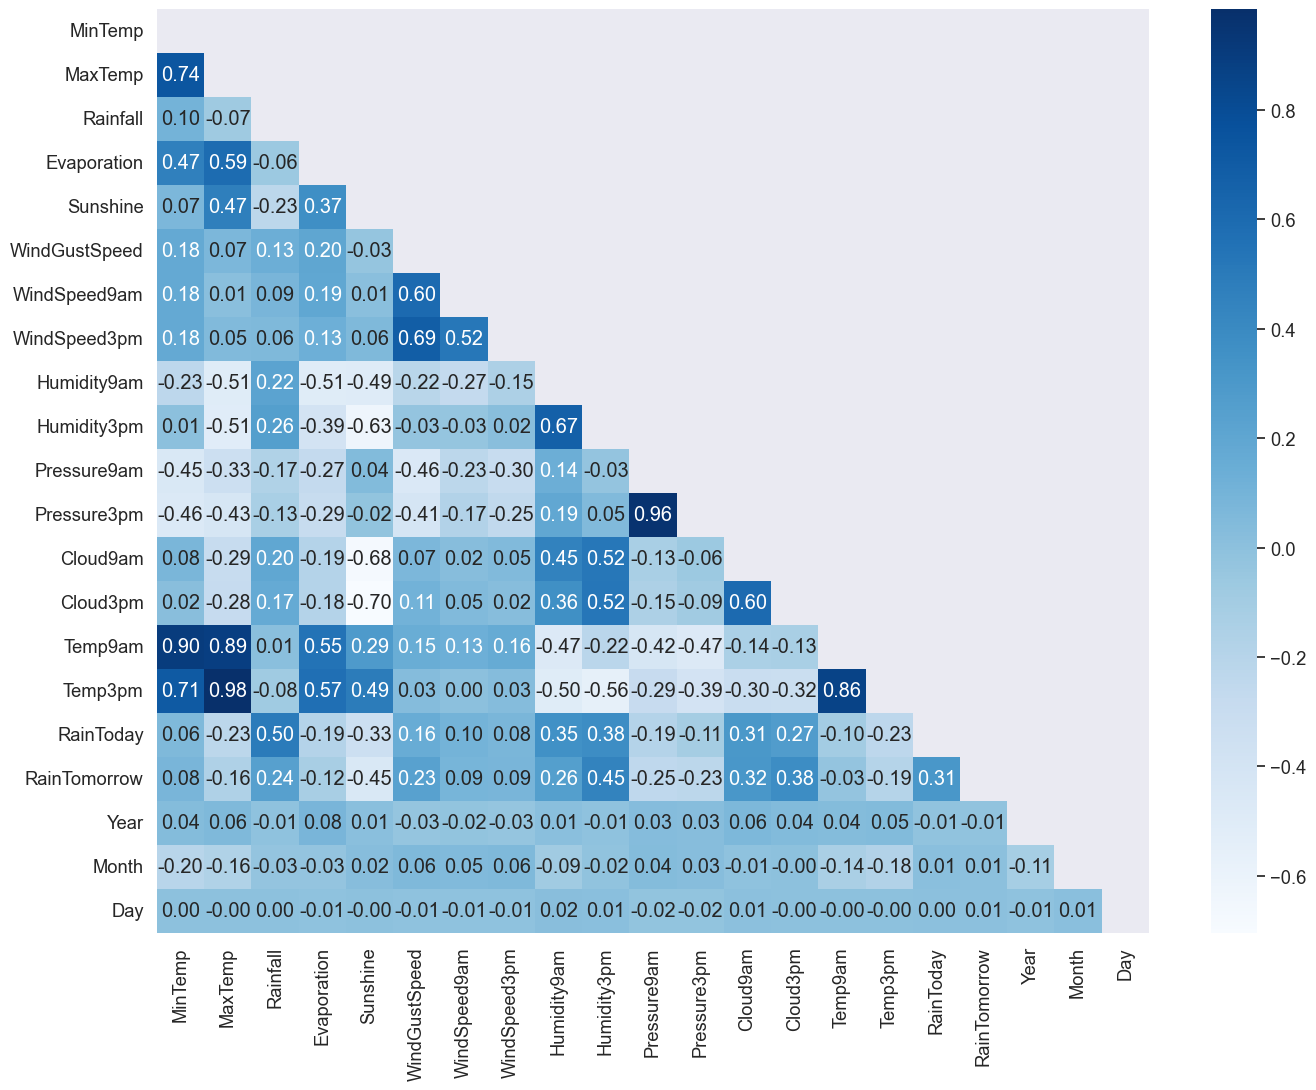

In [21]:
sns.set(font_scale=1.2)
plt.subplots(figsize=(16, 12))

sns_mask = np.triu(np.ones_like(weather_data.corr()))
sns.heatmap(weather_data.corr(), annot=True, mask=sns_mask, cmap='Blues', fmt='.2f')
plt.show()

In [22]:
#Removing highly correlated features
weather_data = weather_data.drop(["Temp9am", "Temp3pm", "Pressure9am"], axis=1)
cols = [i for i in cols if i not in ("Temp9am", "Temp3pm", "Pressure9am")]

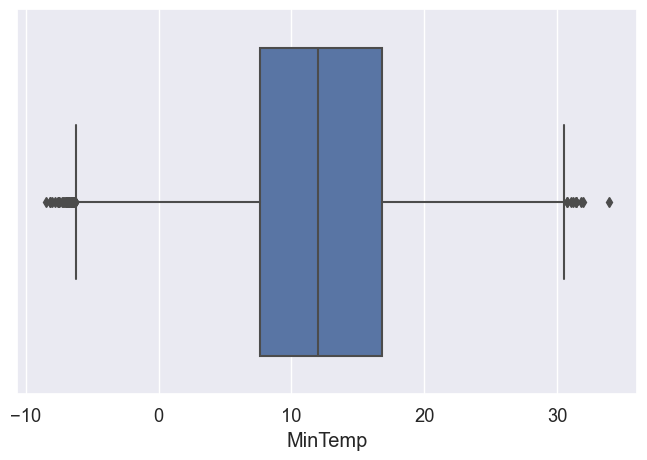

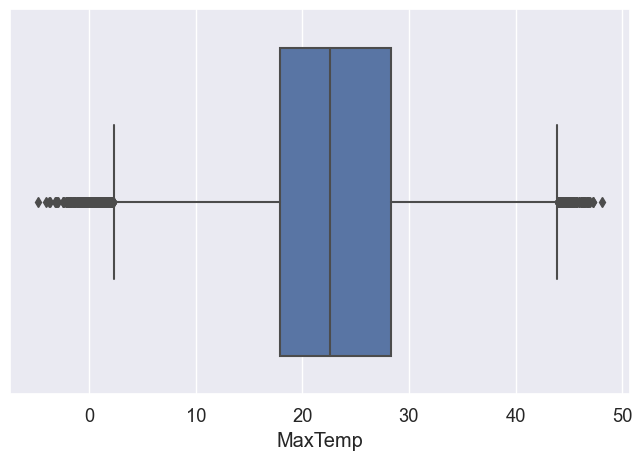

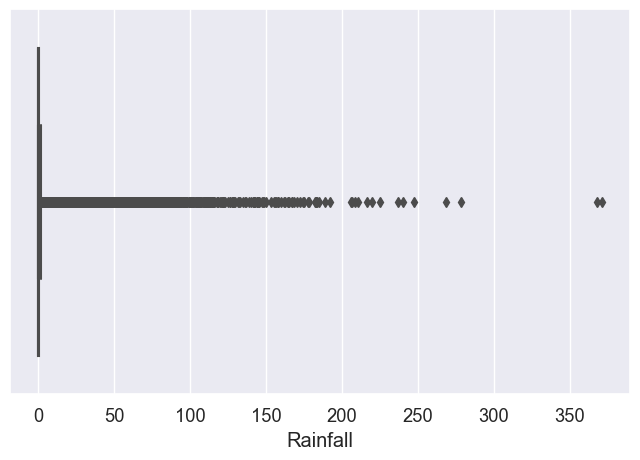

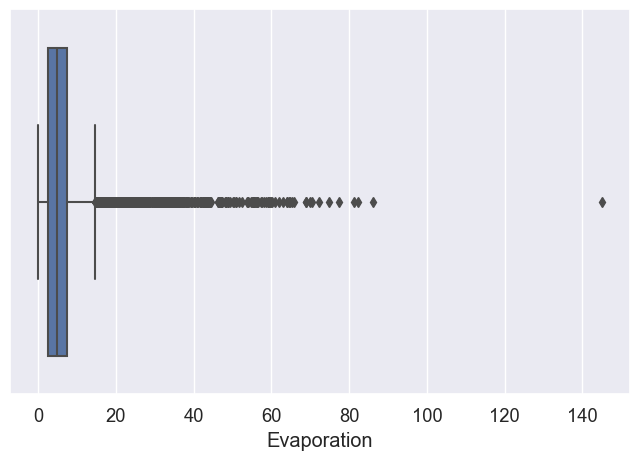

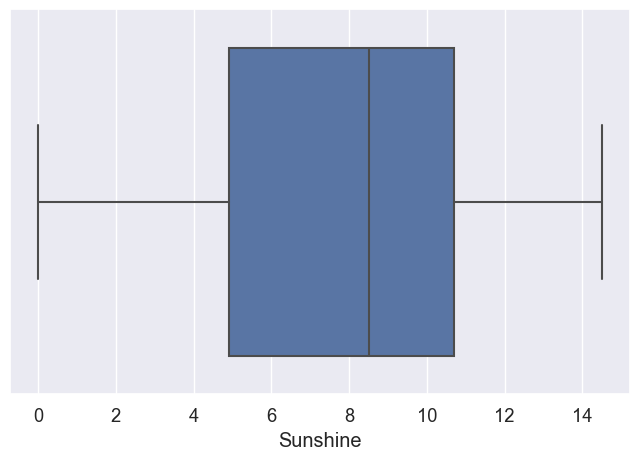

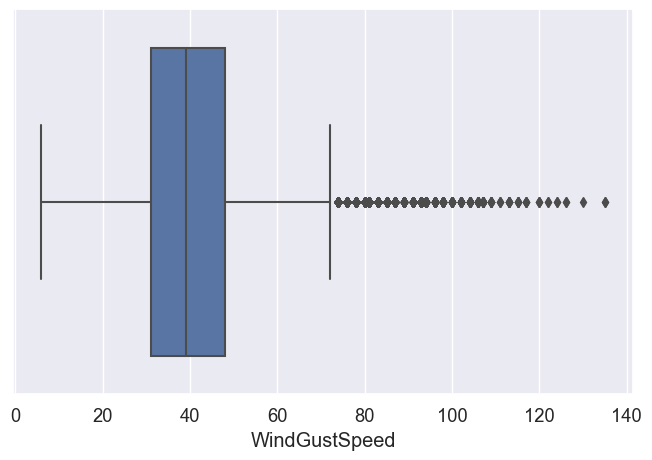

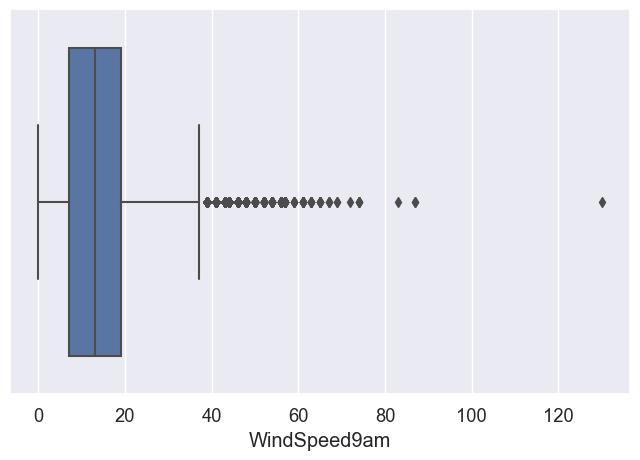

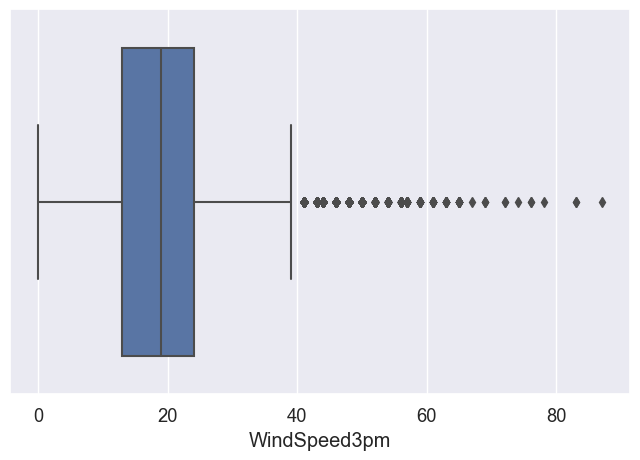

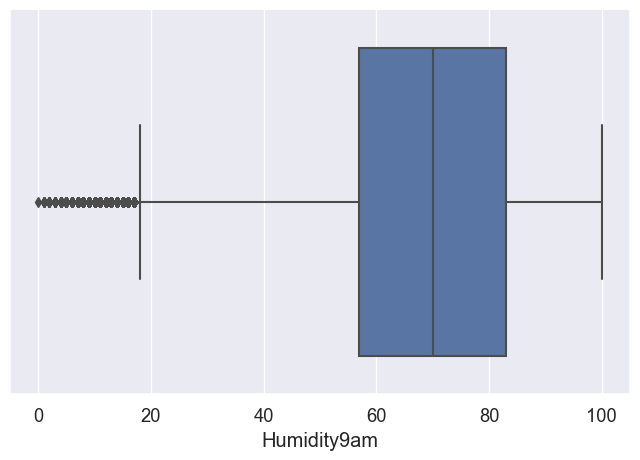

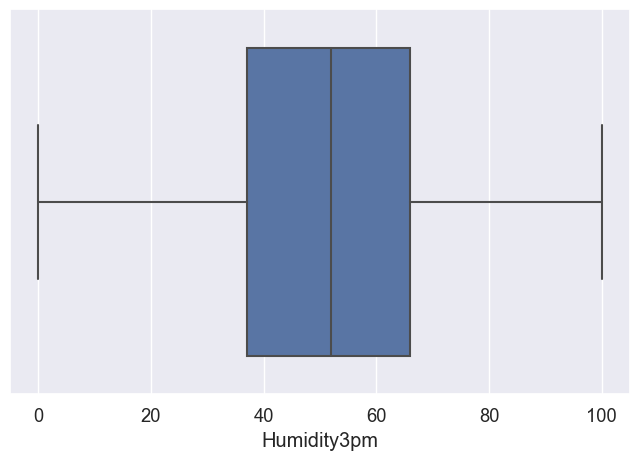

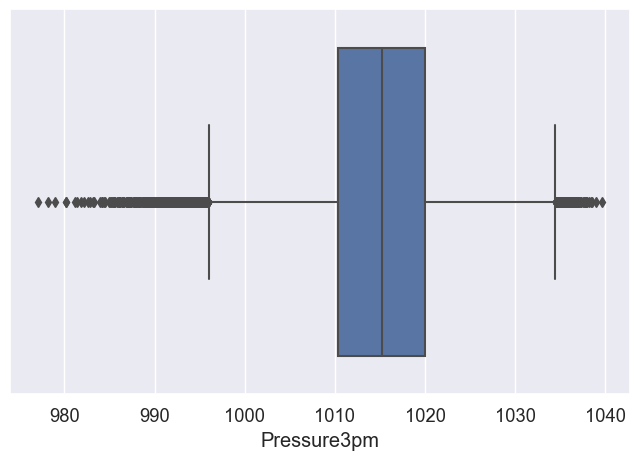

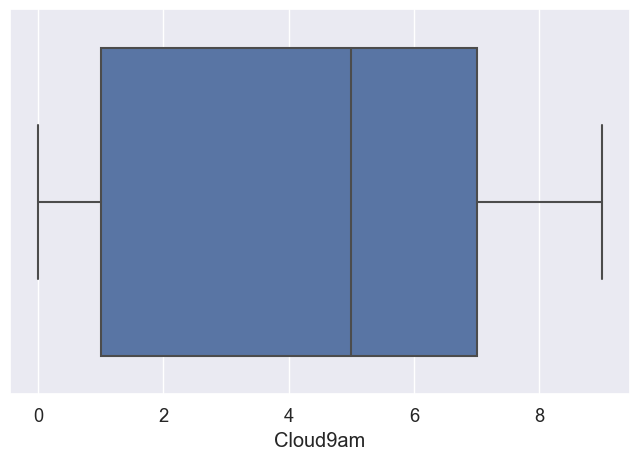

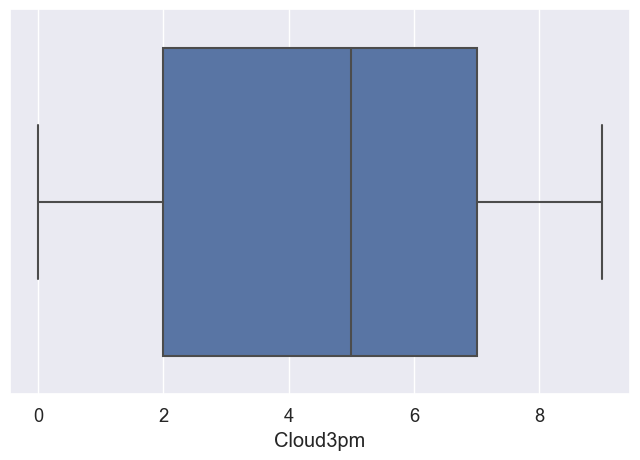

In [23]:
for i in cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=weather_data[i])

In [24]:
weather_data.shape

(140787, 22)

In [25]:
#Removing outliers, excluding "Rainfall" and "Evaporation"
#Removing their outlier values would result in increase of the imbalance of "RainTomorrow" values

outlier_columns = [
    'MinTemp',
    'MaxTemp',
    #'Rainfall',
    #'Evaporation',
    'Sunshine',
    'WindGustSpeed',
    'WindSpeed9am',
    'WindSpeed3pm',
    'Humidity9am',
    'Humidity3pm',
    'Pressure3pm',
    'Cloud9am',
    'Cloud3pm'
]


def is_outlier(df):
    Q1 = df[outlier_columns].quantile(0.25)
    Q3 = df[outlier_columns].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[outlier_columns] < (Q1 - 1.5 * IQR)) | (df[outlier_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]


weather_data = is_outlier(weather_data)

In [26]:
weather_data.shape

(133150, 22)

In [27]:
weather_data['RainToday'].value_counts()

0    104100
1     29050
Name: RainToday, dtype: int64

In [28]:
weather_data['RainTomorrow'].value_counts()

0    104838
1     28312
Name: RainTomorrow, dtype: int64

In [29]:
#Replacing float Na with feature median - grouped by "RainTomorrow"

for i in cols:
    weather_data[i] = weather_data[i].fillna(weather_data.groupby('RainTomorrow')[i].transform('median'))

In [30]:
#Dummies for remaining objects

for i in ["Location", "WindGustDir", "WindDir9am", "WindDir3pm"]:
    dummy = pd.get_dummies(weather_data[i], drop_first=True, prefix=i)
    weather_data = pd.concat([weather_data, dummy], axis=1)
    weather_data = weather_data.drop(i, axis=1)
    
weather_data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,5.0,9.4,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,5.0,9.4,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,5.0,9.4,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,5.0,9.4,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,5.0,9.4,41.0,7.0,20.0,82.0,33.0,...,0,1,0,0,0,0,0,0,0,0


## Model - XGBoost & LightGBM

In [31]:
#Balancing data for model

RainTomorrow_1 = weather_data[weather_data['RainTomorrow']==1]
RainTomorrow_0 = weather_data[weather_data['RainTomorrow']==0].sample(n=28312, random_state=1)
model_train_data = pd.concat([RainTomorrow_0, RainTomorrow_1], axis=0)

print(model_train_data.shape)

(56624, 111)


In [32]:
features = model_train_data.drop(['RainTomorrow'], axis=1)
target = model_train_data['RainTomorrow']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
models = [XGBClassifier(), lgb.LGBMClassifier()]

In [36]:
for i in range(2):
    models[i].fit(X_train, y_train)
    print(f'{models[i]} : ')
    print('Training ROC_AUC_score : ', metrics.roc_auc_score(y_train, models[i].predict_proba(X_train)[:,1]))
    print('Test ROC_AUC_score : ', metrics.roc_auc_score(y_test, models[i].predict_proba(X_test)[:,1]), '\n')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training ROC_AUC_score :  0.9956460328007292
Test ROC_AUC_score :  0.9798132657718526 

LGBMClassifier() : 
Training ROC_AUC_score :  0.9854419477070051
Test ROC_AUC_score :  0.9794267380661306 



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 


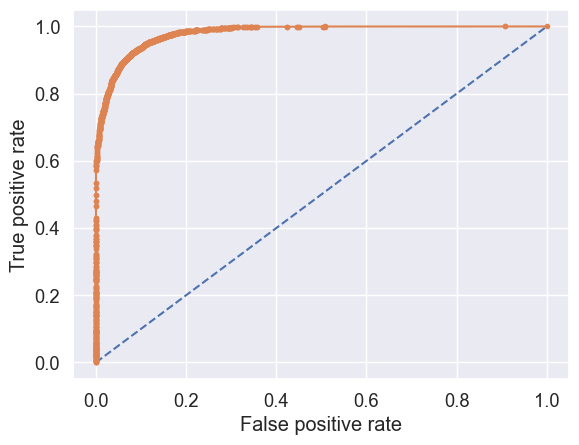

LGBMClassifier() : 


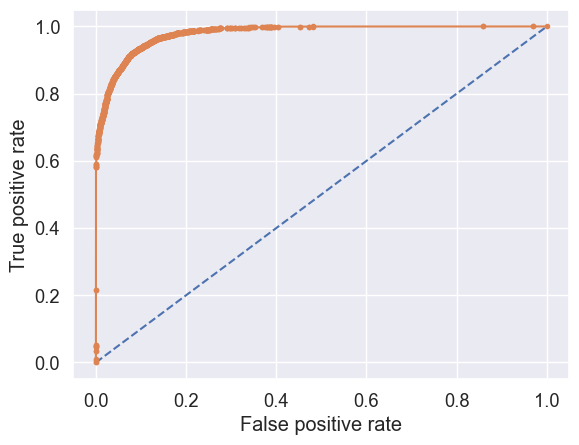

In [37]:
for i in range(2):
    print(f'{models[i]} : ')
    fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(X_test)[:,1])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()